
# Programa Ejemplo para realizar el ajuste de los hiperparámetros en un modelo de clasificación por árboles de decisión.

## Etapa 1: Definición del caso de estudio 

Para este ejercicio usaremos la base de datos [load_digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) disponible en sklearn. La idea de esta base de datos es construir un sistema de aprendizaje automático que permita la identificación del dígito mostrado en cada imagen.

In [1]:
# Carga de librerías y la base de datos

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# Se cargan los datos
digits = datasets.load_digits()
digits.data.shape

(1797, 64)

<Figure size 432x288 with 0 Axes>

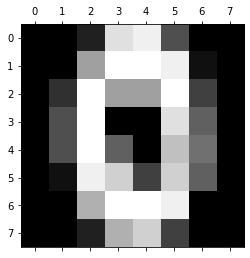

In [2]:
# Se visualizan algunas muestras de la base de datos 

plt.gray()
plt.matshow(digits.images[55])
plt.show()

In [3]:
# Se dividen los datos en los conjuntos de entrenamiento y prueba. 
# Se usa una división 70/30. 
data = digits.data

X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.25, shuffle=False)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1347, 64) (1347,)
(450, 64) (450,)


# Parte 2: Entrenamiento de un sistema de aprendizaje automático eligiendo los hiper-parámetros de forma aleatoria.

Se entrena un clasificador basado en árboles de decisión usando una configuración aleatoria. Debido a la aletoriedad es probable que la la precisión (accuracy) del sistema no sea la adecuada. Sin embargo, recuerden que la idea es usar un algortimo que permita elegir la configuración que nos lleve a obtener el mejor desempeño en el conjunto de prueba. 

In [4]:
clf = DecisionTreeClassifier(random_state=0,
                             criterion = ['gini', 'entropy'][np.random.randint(0, high=1)],
                             min_samples_split = np.random.randint(2, high=4), 
                             min_samples_leaf = np.random.randint(1, high=5), 
                             max_features = ['auto', 'sqrt', 'log2'][np.random.randint(0, high=2)],
                             max_depth =  np.random.randint(5, high=7))
clf.fit(X_train, y_train)
print(classification_report(clf.predict(X_test),y_test))


              precision    recall  f1-score   support

           0       0.74      0.97      0.84        33
           1       0.52      0.31      0.39        78
           2       0.35      0.83      0.49        18
           3       0.43      0.51      0.47        39
           4       0.79      0.83      0.81        46
           5       0.40      0.49      0.44        37
           6       0.64      0.64      0.64        47
           7       0.67      0.94      0.78        32
           8       0.27      0.19      0.22        57
           9       0.62      0.44      0.52        63

    accuracy                           0.55       450
   macro avg       0.54      0.61      0.56       450
weighted avg       0.54      0.55      0.53       450



/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


# Etapa 3: Determinar la mejor configuración del clasificador basado en árboles de decisión

La idea es llevar a cabo una búsqueda que permita encontrar la combinación de hiper-parámetros que maximice el rendimiento del clasificador. Particularmente se estudian tres enfoques: Búsqueda por Grilla, Búsqueda aleatoria y Optimización Bayesiana.

In [5]:
# Se define el espacio de búsqueda. 

param_grid = {
    'criterion': ['gini', 'entropy'], # 2 opciones
    'min_samples_split': [2, 3, 4], # 3 opciones
    'min_samples_leaf': [1, 2, 3, 4, 5], # 5 opciones
    'max_features': ['auto', 'sqrt', 'log2'], # 3 opciones
    'max_depth': [5, 6, 7] # 3 opciones
    }

# La idea es probar todas las posibles configuraciones de los parámetros con el 
# fin de encontrar la que mejores resultados ofezca.
# Así se deben analizar 3*3*5*3*3=270 posibilidades

## 3.1 Validación cruzada

Con el fin de realizar la búsqueda de parámetros el conjunto de entrenamiento se divide es dos: conjunto de entrenamiento y conjunto de validación, el conjunto de validación se emplea para calcular la combinación de parámetros libres que maximiza el rendimiento del clasificador.

![texto del enlace](https://github.com/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/grid_search_cross_validation.png?raw=true)

## 3.2 Búsqueda por grilla. 

La idea para este enfoque es probar exhaustivamente todas las posibles combinaciones generadas por el espacio de búsqueda. 

In [6]:
# Se crea el objeto para la búsqueda por grilla
clf = DecisionTreeClassifier(random_state=0)
gs = GridSearchCV(estimator=clf, # El clasificador elegido
                  param_grid=param_grid, # la grilla de parámetros
                  scoring='accuracy', # la medida de desempeño
                  cv=5, # para la búsqueda, el conjunto de entrenamiento se divide
                        # en dos: Entrenamiento y validación. cv indica cuántas
                        # veces se repetirá dicha división
                  n_jobs=-1,
                  verbose=2)

# Se mide el tiempo de ejecución
time_start = time.time()
gs.fit(X_train, y_train) 
time_grid = time.time() - time_start

# se guardan los resultados en un pandas dataframe 
values_grid = [405, gs.best_score_, time_grid]
columns = ['Número de iteraciones', 'Mejor accuracy', 'Tiempo empleado']
results_grid = pd.DataFrame([values_grid], columns = columns)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [7]:
# se analiza el rendimiento de la mejor configuración sobre el conjunto de prueba

print(classification_report(gs.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        47
           1       0.74      0.67      0.70        51
           2       0.84      0.90      0.87        40
           3       0.68      0.74      0.71        43
           4       0.77      0.80      0.79        46
           5       0.78      0.80      0.79        44
           6       0.74      0.95      0.83        37
           7       0.80      0.97      0.88        37
           8       0.71      0.47      0.56        62
           9       0.62      0.65      0.64        43

    accuracy                           0.76       450
   macro avg       0.76      0.78      0.76       450
weighted avg       0.76      0.76      0.75       450



## 3.3 Búsqueda aleatoria

A diferencia de la búsqueda por grilla, en la búsqueda aleatoria la idea es escoger de forma aleatoria diferentes configuraciones de parámetros hasta encontrar la que produzca el mejor rendimiento. 

In [8]:
# Se crea el objeto para la búsqueda aleatoria
clf = DecisionTreeClassifier(random_state=0)
rs = RandomizedSearchCV(estimator=clf,
                  param_distributions=param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1,
                  verbose=2,
                  n_iter=100 # Se define un número máximo de búsqueda
                  )

# búsqueda de la mejor configuración
time_start = time.time()
rs.fit(X_train, y_train)
time_random = time.time() - time_start

# se almacenna los resultados
values_grid = [[100,rs.best_score_, time_random]]
results_random = pd.DataFrame(values_grid, columns = columns)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


In [9]:
# se analiza el rendimiento de la mejor configuración sobre el conjunto de prueba

print(classification_report(rs.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        47
           1       0.74      0.67      0.70        51
           2       0.84      0.90      0.87        40
           3       0.68      0.74      0.71        43
           4       0.77      0.80      0.79        46
           5       0.78      0.80      0.79        44
           6       0.74      0.95      0.83        37
           7       0.80      0.97      0.88        37
           8       0.71      0.47      0.56        62
           9       0.62      0.65      0.64        43

    accuracy                           0.76       450
   macro avg       0.76      0.78      0.76       450
weighted avg       0.76      0.76      0.75       450



## 3.4 Optimización Bayesiana

Este método emplea los conceptos de la inferencia Bayesiana para encontrar la mejor configuración para el clasificador.

In [10]:
# Se instala la librería requerida
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.4 MB/s eta 0:00:00


In [11]:
from skopt import BayesSearchCV
# parameter ranges are specified by one of below
from skopt.space import Real, Categorical, Integer
clf = DecisionTreeClassifier(random_state=0)
search_spaces = {
  'criterion': ['gini', 'entropy'],
  'min_samples_split': (2,4), # 3 opciones
  'min_samples_leaf': (1,5), # 5 opciones
  'max_features': ['auto', 'sqrt', 'log2'], # 3 opciones
  'max_depth': (5, 7) # 3 opciones
}


By =  BayesSearchCV(clf,
                    search_spaces,
                    cv=5,
                    n_iter=30
)

# se mide el tiempo de ejecución
time_start = time.time()
By.fit(X_train, y_train)
time_bayesian = time.time() - time_start

# # se almacena la mejor configuración
values_bayesian = [30, By.best_score_, time_bayesian]
results_bayesian = pd.DataFrame([values_bayesian], columns = columns)

/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9

In [12]:
# se analiza el rendimiento de la mejor configuración sobre el conjunto de prueba

print(classification_report(By.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87        47
           1       0.74      0.67      0.70        51
           2       0.84      0.90      0.87        40
           3       0.68      0.74      0.71        43
           4       0.77      0.80      0.79        46
           5       0.78      0.80      0.79        44
           6       0.74      0.95      0.83        37
           7       0.80      0.97      0.88        37
           8       0.71      0.47      0.56        62
           9       0.62      0.65      0.64        43

    accuracy                           0.76       450
   macro avg       0.76      0.78      0.76       450
weighted avg       0.76      0.76      0.75       450



In [13]:
df = results_grid.append(results_random).append(results_bayesian)
df.index = ['Grid Search', 'Random Search', 'Bayesian Optimization']
df

<ipython-input-13-56cc308f9353>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = results_grid.append(results_random).append(results_bayesian)


,Número de iteraciones,Mejor accuracy,Tiempo empleado
Grid Search,405,0.727578,12.328252
Random Search,100,0.727578,5.022002
Bayesian Optimization,30,0.727578,48.509138


# Fin del programa